load xyz file into colab

ensure Runtime -> Change Runtime Type is GPU (not CPU), otherwise slow

In [ ]:
!wget https://github.com/hruska-lab/labshared/raw/main/quickinstall.zip

--2023-12-13 17:24:22--  https://github.com/hruska-lab/labshared/raw/main/quickinstall.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hruska-lab/labshared/main/quickinstall.zip [following]
--2023-12-13 17:24:22--  https://raw.githubusercontent.com/hruska-lab/labshared/main/quickinstall.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49981916 (48M) [application/zip]
Saving to: ‘quickinstall.zip’

quickinstall.zip    100%[===================>]  47.67M   242MB/s    in 0.2s    

2023-12-13 17:24:23 (242 MB/s) - ‘quickinstall.zip’ saved [49981916/49981916]



In [ ]:
!unzip quickinstall.zip ;

Archive:  quickinstall.zip
   creating: quickinstall/
   creating: quickinstall/bin/
  inflating: quickinstall/bin/test-api  
  inflating: quickinstall/bin/quick.cuda  
  inflating: quickinstall/bin/test-api.cuda.MPI  
  inflating: quickinstall/bin/quick  
  inflating: quickinstall/bin/quick.MPI  
  inflating: quickinstall/bin/test-api.MPI  
  inflating: quickinstall/bin/test-api.cuda  
  inflating: quickinstall/bin/quick.cuda.MPI  
   creating: quickinstall/include/
   creating: quickinstall/include/libxc/
   creating: quickinstall/include/libxc/gpu/
 extracting: quickinstall/include/libxc/gpu/libxc_funcs_m.mod  
  inflating: quickinstall/include/libxc/gpu/xc_f90_lib_m.mod  
 extracting: quickinstall/include/libxc/gpu/xc_f90_types_m.mod  
   creating: quickinstall/include/libxc/serial/
 extracting: quickinstall/include/libxc/serial/libxc_funcs_m.mod  
  inflating: quickinstall/include/libxc/serial/xc_f90_lib_m.mod  
 extracting: quickinstall/include/libxc/serial/xc_f90_types_m.mod  
 

For any molecule:
* first line parameters
* Basis set STO-3G is not accurate enough, 6-31G(d) is acceptable
* Documentation https://quick-docs.readthedocs.io/en/latest/user-manual.html
* then empty line
* then add xyz data

In [ ]:
# line with options ENERGY or OPTIMIZATION,
text=["DFT BASIS=6-31G B3LYP D3 CUTOF ENERGY\n"]


#reading xyz
with open('new_localmin_1.xyz') as f:
    xyzfile = f.readlines()

text=text+['\n']+xyzfile[3:]

with open("quick-diclofenac-6-31G.in", "w") as f:
    f.writelines(text)

In [ ]:
#takes about 2.5 min on GPU ( on CPU 9 min)
!source /content/quickinstall/quick.rc; quick.cuda quick-diclofenac-6-31G.in

check convergence of electron density/scf

In [ ]:
! grep -a "REACH CONVERGENCE" quick-diclofenac-6-31G.out

| REACH CONVERGENCE AFTER  76 CYCLES


In [ ]:
! grep -a "TOTAL TIME" quick-diclofenac-6-31G.out

| TOTAL TIME          =   113.891789000


## total energy in *.out file under "TOTAL ENERGY"

In [ ]:
! grep -a "TOTAL ENERGY" quick-diclofenac-6-31G.out

 TOTAL ENERGY         =   -782.382458799


In [ ]:
# extract from .out file the total energy calculated by DFT in hartree units
with open('quick-diclofenac-6-31G.out') as f:
    content= f.readlines()
    for line in content:
      if "TOTAL ENERGY" in line:
        e_tot=float(line.split()[-1])

print(e_tot, "hartree")

-782.382458799 hartree


energy printed in units of Hartree, convert to kJ/mol https://ryutok.github.io/EnergyConversionTable/


In [ ]:
energia_molekuly = e_tot*2625.50
print(e_tot*2625.50, 'kJ/mol')

-2054145.1455767746 kJ/mol


for comparison at 25 Celsius temperature Boltzmann distribution is around 2.479 kJ/mol

estimation of Hydrogen affinity by removing one hydrogen and subtracting energies
* Systems with unpaired electrons - switch to UDFT



In [ ]:
%pip install -q pyscf py3DMol plotly kaleido
!pip install rdkit
from pyscf import gto, scf, dft, mp, cc, fci
import py3Dmol
import plotly.express as px
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw, rdDetermineBonds, AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.annotationFontScale = 1.4
from rdkit.Chem.Draw import rdMolDraw2D
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 43.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [ ]:
with open('new_localmin_1.xyz') as f:
    content = f.readlines()
rozdiely = []
for n in range(1,12):
#  content_cut=content[:20+n]+content[20+n+1:]
  content_cut=["UDFT BASIS=6-31G B3LYP D3 CUTOF ENERGY\n"]+['\n']+content[2:20+n]+content[20+n+1:]
  f = open("diclofenac_noH"+str(n)+".txt", "w")
  f.writelines(content_cut)
  f.close()
  cmd='source /content/quickinstall/quick.rc; quick.cuda diclofenac_noH' + str(n) +'.txt'
  !{cmd}
#  ! grep -a "REACH CONVERGENCE" 'diclofenac_noH' + str(n) +'.txt'
#  ! grep -a "TOTAL ENERGY" 'diclofenac_noH' + str(n) +'.out'
  with open("diclofenac_noH"+str(n)+".out") as f:
    content_out = f.readlines()
    for line in content_out:
      if "TOTAL ENERGY" in line:
        e_tot=float(line.split()[-1])
  rozdiely.append(float(e_tot*2625.50 - energia_molekuly))

^C
^C
^C


In [ ]:
rozdiely = []
for n in range(1,12):
  with open("diclofenac_noH"+str(n)+".out") as f:
      content_out = f.readlines()
      for line in content_out:
        if "TOTAL ENERGY" in line:
          e_tot=float(line.split()[-1])
  rozdiely.append(float(e_tot*2625.50 - energia_molekuly))

In [ ]:
min = np.min(rozdiely)
for i in range (11):
  rozdiely[i] = rozdiely[i] - min

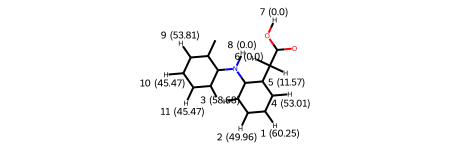

In [ ]:
def label_H( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
      if mol.GetAtomWithIdx(idx).GetSymbol()=='H':
        #mol.GetAtomWithIdx( idx ).SetProp('atomNote', str(idx-18), str(y))
        mol.GetAtomWithIdx( idx ).SetProp( 'atomNote', str(idx-18) + ' (' + str(round(rozdiely[idx-19], 2)) + ')')
    return mol
mol = Chem.MolFromXYZFile('new_localmin_1.xyz')
rdDetermineBonds.DetermineConnectivity(mol)
AllChem.Compute2DCoords(mol)
mol_labeledH=label_H( mol )
mol_labeledH

In [ ]:
Draw.MolToFile(mol_labeledH, "figure_diclofenac_labeled_with_energy_H.png")

In [ ]:
d = rdMolDraw2D.MolDraw2DCairo(350, 300)
d.SetFontSize(14)
d.DrawMolecule(mol_labeledH)
d.FinishDrawing()
d.WriteDrawingText('figure_diclofenac_labeled_with_energy_H_font.png')